# COVID-19

Here we will be analyzing the COVID-19 datasets from kaggle.

In [53]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

Load the cleaned data from https://www.kaggle.com/imdevskp/corona-virus-report.

In [54]:
cleaned_data = pd.read_csv('covid_19_clean.csv', parse_dates=['Date'])

cleaned_data.rename(columns={'ObservationDate': 'date', 
                     'Province/State':'state',
                     'Country/Region':'country',
                     'Last Update':'last_updated',
                     'Confirmed': 'confirmed',
                     'Deaths':'deaths',
                     'Recovered':'recovered'
                    }, inplace=True)

# cases 
cases = ['confirmed', 'deaths', 'recovered', 'active']

# Active Case = confirmed - deaths - recovered
cleaned_data['active'] = cleaned_data['confirmed'] - cleaned_data['deaths'] - cleaned_data['recovered']

# replacing Mainland china with just China
cleaned_data['country'] = cleaned_data['country'].replace('Mainland China', 'China')

# filling missing values 
cleaned_data[['state']] = cleaned_data[['state']].fillna('')
cleaned_data[cases] = cleaned_data[cases].fillna(0)
cleaned_data.rename(columns={'Date':'date'}, inplace=True)

data = cleaned_data

display(data.head())
display(data.info())

,state,country,Lat,Long,date,confirmed,deaths,recovered,active
0,,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0,0
1,,Albania,41.1533,20.1683,2020-01-22,0,0,0,0
2,,Algeria,28.0339,1.6596,2020-01-22,0,0,0,0
3,,Andorra,42.5063,1.5218,2020-01-22,0,0,0,0
4,,Angola,-11.2027,17.8739,2020-01-22,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16884 entries, 0 to 16883
Data columns (total 9 columns):
state        16884 non-null object
country      16884 non-null object
Lat          16884 non-null float64
Long         16884 non-null float64
date         16884 non-null datetime64[ns]
confirmed    16884 non-null int64
deaths       16884 non-null int64
recovered    16884 non-null int64
active       16884 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 1.2+ MB


None

In [55]:
data.country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [56]:
# Check if the data is updated
print("External Data")
print(f"Earliest Entry: {data['date'].min()}")
print(f"Last Entry:     {data['date'].max()}")
print(f"Total Days:     {data['date'].max() - data['date'].min()}")

External Data
Earliest Entry: 2020-01-22 00:00:00
Last Entry:     2020-03-28 00:00:00
Total Days:     66 days 00:00:00


## 1. Infections and Fatalities Worldwide

In the two plots above we can see the number of infected and deceased people across the world.

## 2. Normalized Infection and Fatality Ratio
We wish to have a closer look at the infection and fatality ratio, when normalized by country population size. This will surely give us an interesting perspective as to which countries are doing better and which ones are not.

In [57]:
def p2f(x):
    """
    Convert urban percentage to float
    """
    try:
        return float(x.strip('%'))/100
    except:
        return np.nan

def age2int(x):
    """
    Convert Age to integer
    """
    try:
        return int(x)
    except:
        return np.nan

def fert2float(x):
    """
    Convert Fertility Rate to float
    """
    try:
        return float(x)
    except:
        return np.nan


countries_df = pd.read_csv("population_by_country_2020.csv", converters={'Urban Pop %':p2f,
                                                                                                             'Fert. Rate':fert2float,
                                                                                                             'Med. Age':age2int})
countries_df.rename(columns={'Country (or dependency)': 'country',
                             'Population (2020)' : 'population',
                             'Density (P/Km²)' : 'density',
                             'Fert. Rate' : 'fertility',
                             'Med. Age' : "age",
                             'Urban Pop %' : 'urban_percentage'}, inplace=True)



countries_df['country'] = countries_df['country'].replace('United States', 'US')
countries_df = countries_df[["country", "population", "density", "fertility", "age", "urban_percentage"]]

countries_df.head()

,country,population,density,fertility,age,urban_percentage
0,China,1439323776,153,1.7,38.0,0.61
1,India,1380004385,464,2.2,28.0,0.35
2,US,331002651,36,1.8,38.0,0.83
3,Indonesia,273523615,151,2.3,30.0,0.56
4,Pakistan,220892340,287,3.6,23.0,0.35


In [58]:
data = pd.merge(data, countries_df, on='country')

Now this is interesting, because we can clearly see here in which countries the virus has infected most people.
It can clearly be seen that countries with a small population, such as San Marino, Andorra, Luxembourg and Switzerland have a relatively high percentage of infection ratio. Nonetheless, the infection percentage is still relatively low below 0.5%.

Let's have a closer look at the World map of the normalized infection ratio by population:

In [59]:
formated_gdf = data.groupby(['date', 'country'])['confirmed', 'population'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['date'] = pd.to_datetime(formated_gdf['date'])
formated_gdf['date'] = formated_gdf['date'].dt.strftime('%m/%d/%Y')
formated_gdf['infectionRate'] = round((formated_gdf['confirmed']/formated_gdf['population'])*100, 8)

fig = px.scatter_geo(formated_gdf, locations="country", locationmode='country names', 
                     color="infectionRate", size='infectionRate', hover_name="country", 
                     range_color= [0, 0.2], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Spread Over Time (Normalized by Country Population)', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()

In [60]:
cleaned_latest = data[data['date'] == max(data['date'])]
flg = cleaned_latest.groupby('country')['confirmed', 'deaths', 'recovered', 'active'].sum().reset_index()

flg['mortalityRate'] = round((flg['deaths']/flg['confirmed'])*100, 2)
temp = flg[flg['confirmed']>100]
temp = temp.sort_values('mortalityRate', ascending=False)

fig = px.bar(temp.sort_values(by="mortalityRate", ascending=False)[:10][::-1],
             x = 'mortalityRate', y = 'country', 
             title='Deaths per 100 Confirmed Cases', text='mortalityRate', height=800, orientation='h',
             color_discrete_sequence=['darkred']
            )
fig.show()

Again, let's have a look at the evolution of mortality rate.

In [61]:
formated_gdf = data.groupby(['date', 'country'])['confirmed', 'deaths'].max()
formated_gdf = formated_gdf.reset_index()
formated_gdf['date'] = pd.to_datetime(formated_gdf['date'])
formated_gdf['date'] = formated_gdf['date'].dt.strftime('%m/%d/%Y')
formated_gdf['mortalityRate'] = round((formated_gdf['deaths']/formated_gdf['confirmed'])*100, 2)

fig = px.scatter_geo(formated_gdf.fillna(0), locations="country", locationmode='country names', 
                     color="mortalityRate", size='mortalityRate', hover_name="country", 
                     range_color= [0, 10], 
                     projection="natural earth", animation_frame="date", 
                     title='COVID-19: Mortality Rate in % by country', color_continuous_scale="portland")
# fig.update(layout_coloraxis_showscale=False)
fig.show()

## 4. Temperature Data
In our next step, we wish to analyze the weather and temperature data of the respective countries since the outbreak of the virus. We have composed a dataset here: https://www.kaggle.com/winterpierre91/covid19-global-weather-data

We hope to find some colleration between certain weather metrics and the speed of the number of infections/deaths.

In [62]:
df_temperature = pd.read_csv("temperature_dataframe.csv")
df_temperature['country'] = df_temperature['country'].replace('USA', 'US')
df_temperature['country'] = df_temperature['country'].replace('UK', 'United Kingdom')
df_temperature = df_temperature[["country", "province", "date", "humidity", "sunHour", "tempC", "windspeedKmph"]].reset_index()
df_temperature.rename(columns={'province': 'state'}, inplace=True)
df_temperature["date"] = pd.to_datetime(df_temperature['date'])
df_temperature['state'] = df_temperature['state'].fillna('')


df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16677 entries, 0 to 16676
Data columns (total 8 columns):
index            16677 non-null int64
country          16677 non-null object
state            16677 non-null object
date             16677 non-null datetime64[ns]
humidity         16500 non-null float64
sunHour          16500 non-null float64
tempC            16500 non-null float64
windspeedKmph    16500 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.0+ MB


In [63]:
data = data.merge(df_temperature, on=['country','date', 'state'], how='inner')
data.to_csv("countries_temp.csv")

In [64]:
data.head()

,state,country,Lat,Long,date,confirmed,deaths,recovered,active,population,density,fertility,age,urban_percentage,index,humidity,sunHour,tempC,windspeedKmph
0,,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38928346,60,4.6,18.0,0.25,0,65.0,8.7,-1.0,8.0
1,,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38928346,60,4.6,18.0,0.25,1,59.0,8.7,-3.0,8.0
2,,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38928346,60,4.6,18.0,0.25,2,71.0,7.1,0.0,7.0
3,,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38928346,60,4.6,18.0,0.25,3,79.0,8.7,0.0,7.0
4,,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38928346,60,4.6,18.0,0.25,4,64.0,8.7,-1.0,8.0


# Regression Model
By implementing a regression model which tries to use the country input variables to predict the most recent number of infections and deaths as target, we can extract the relative feature importance. This can be done pretty well with a Random Forest Regressor.

In [65]:
train_data = data
print(train_data.shape)
train_data.head()

(11638, 19)


,state,country,Lat,Long,date,confirmed,deaths,recovered,active,population,density,fertility,age,urban_percentage,index,humidity,sunHour,tempC,windspeedKmph
0,,Afghanistan,33.0,65.0,2020-01-22,0,0,0,0,38928346,60,4.6,18.0,0.25,0,65.0,8.7,-1.0,8.0
1,,Afghanistan,33.0,65.0,2020-01-23,0,0,0,0,38928346,60,4.6,18.0,0.25,1,59.0,8.7,-3.0,8.0
2,,Afghanistan,33.0,65.0,2020-01-24,0,0,0,0,38928346,60,4.6,18.0,0.25,2,71.0,7.1,0.0,7.0
3,,Afghanistan,33.0,65.0,2020-01-25,0,0,0,0,38928346,60,4.6,18.0,0.25,3,79.0,8.7,0.0,7.0
4,,Afghanistan,33.0,65.0,2020-01-26,0,0,0,0,38928346,60,4.6,18.0,0.25,4,64.0,8.7,-1.0,8.0


(We only wish to have a look at countries which already have an infection ratio higher than 0, because the ones that aren't infected yet, might bias the feature importance)

In [66]:
threshold = 0
train_data['infectionRate'] = round((train_data['confirmed']/train_data['population'])*100, 5)
train_data = train_data[train_data['infectionRate'] >= threshold]
print(train_data.shape)

(11638, 20)


In [67]:
train_data = train_data.drop([
                     "country", 
                     "active", 
                     "recovered", 
                     "infectionRate",
                     "state",
                     "Lat",
                     "Long",
                     "date",
                     "index"
                    ], axis= 1).dropna()

y = train_data[["confirmed", "deaths"]]
X = train_data.drop(["confirmed", "deaths"],axis=1)

display(X.head())
print(X.shape, y.shape)

,population,density,fertility,age,urban_percentage,humidity,sunHour,tempC,windspeedKmph
0,38928346,60,4.6,18.0,0.25,65.0,8.7,-1.0,8.0
1,38928346,60,4.6,18.0,0.25,59.0,8.7,-3.0,8.0
2,38928346,60,4.6,18.0,0.25,71.0,7.1,0.0,7.0
3,38928346,60,4.6,18.0,0.25,79.0,8.7,0.0,7.0
4,38928346,60,4.6,18.0,0.25,64.0,8.7,-1.0,8.0


(11160, 9) (11160, 2)


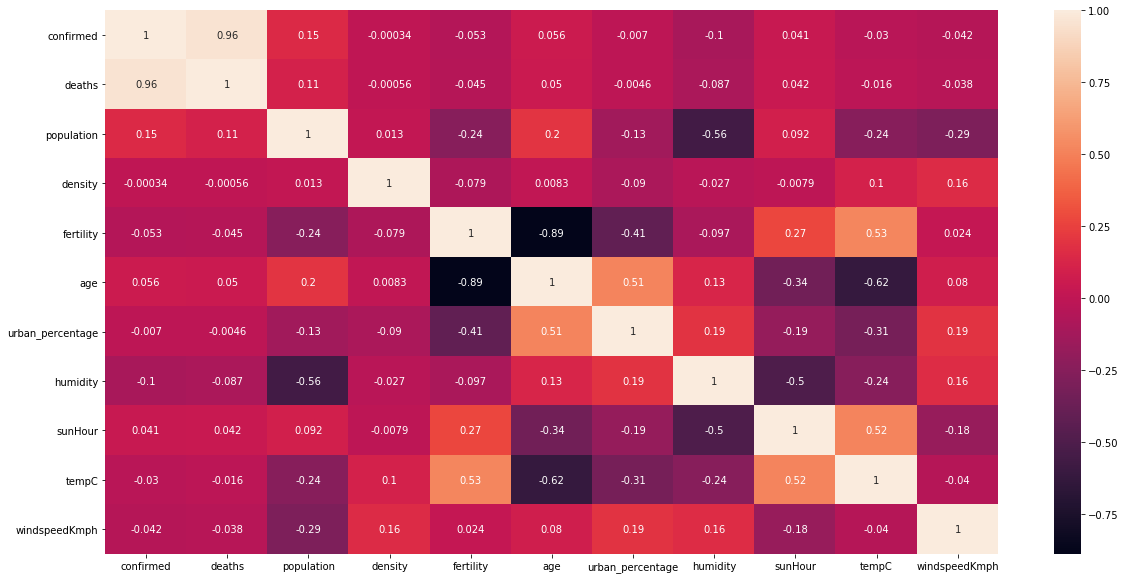

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = train_data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True)

## Train and Evaluate Model (Random Forest)

In [69]:
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [70]:
# Split into training and evaluation data:
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_log_error, make_scorer
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error of a prediction set.
    params:
        y_true: numpy array of ground truth
        y_pred: numpy array of predictions
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle)

X_train, X_val, y_train, y_val = tts(X, y, test_size= 0.2, random_state=42, shuffle=True)

In [71]:
model_infected = DecisionTreeRegressor(random_state=42, criterion="mae")

scores = cross_val_score(model_infected, 
                      X_train,
                      y_train["confirmed"],
                      cv=5, scoring=rmsle_scorer)

print("Cross Validation of Confirmed Cases: Mean = {}, std = {}".format(scores.mean(), scores.std()))
model_infected.fit(X_train, y_train["confirmed"])
result_infected = rmsle(y_val["confirmed"], model_infected.predict(X_val))
print("Validation Infected set RMSLE: {}".format(result_infected))

Cross Validation of Confirmed Cases: Mean = 1.6327518193020516, std = 0.08555062324457507
Validation Infected set RMSLE: 1.6502984888094776


In [72]:
model_deaths = DecisionTreeRegressor(random_state=42, criterion="mae")

scores = cross_val_score(model_deaths, 
                      X_train,
                      y_train["deaths"],
                      cv=5, scoring=rmsle_scorer)

print("Cross Validation of Fatal Cases: Mean = {}, std = {}".format(scores.mean(), scores.std()))
model_deaths.fit(X_train, y_train["deaths"])
result_deaths = rmsle(y_val["deaths"], model_deaths.predict(X_val))
print("Validation Death set RMSLE: {}".format(result_deaths))

Cross Validation of Fatal Cases: Mean = 0.7395098808089781, std = 0.03194760192877866
Validation Death set RMSLE: 0.7192337354005376


In [73]:
# Final Evalutation
print("Final Validatio score: {}".format(np.mean([result_infected, result_deaths])))

Final Validatio score: 1.1847661121050077


## Extract Features for Infections

In [74]:
model_infected = model_infected.fit(X, y["confirmed"])
model_deaths = model_deaths.fit(X, y["deaths"])

In [75]:
def show_feature_importance(forest):
    """
    Creates a sorted list of the feature importance of a decision tree algorithm.
    Furthermore it plots it.
    params:
        forest: Decision Tree algorithm
    """
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("{}, Feature: {}, Importance: {}".format(f + 1, X.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure(figsize=(20,10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X.shape[1]),  X.columns[indices], rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

Feature ranking:
1, Feature: sunHour, Importance: 0.2910944503689061
2, Feature: tempC, Importance: 0.28727750756452597
3, Feature: humidity, Importance: 0.18609384347283295
4, Feature: population, Importance: 0.14089092343572535
5, Feature: windspeedKmph, Importance: 0.09064968224655583
6, Feature: age, Importance: 0.0019496536357409763
7, Feature: urban_percentage, Importance: 0.0013286689035121781
8, Feature: density, Importance: 0.0005093592044459865
9, Feature: fertility, Importance: 0.00020591116775474459


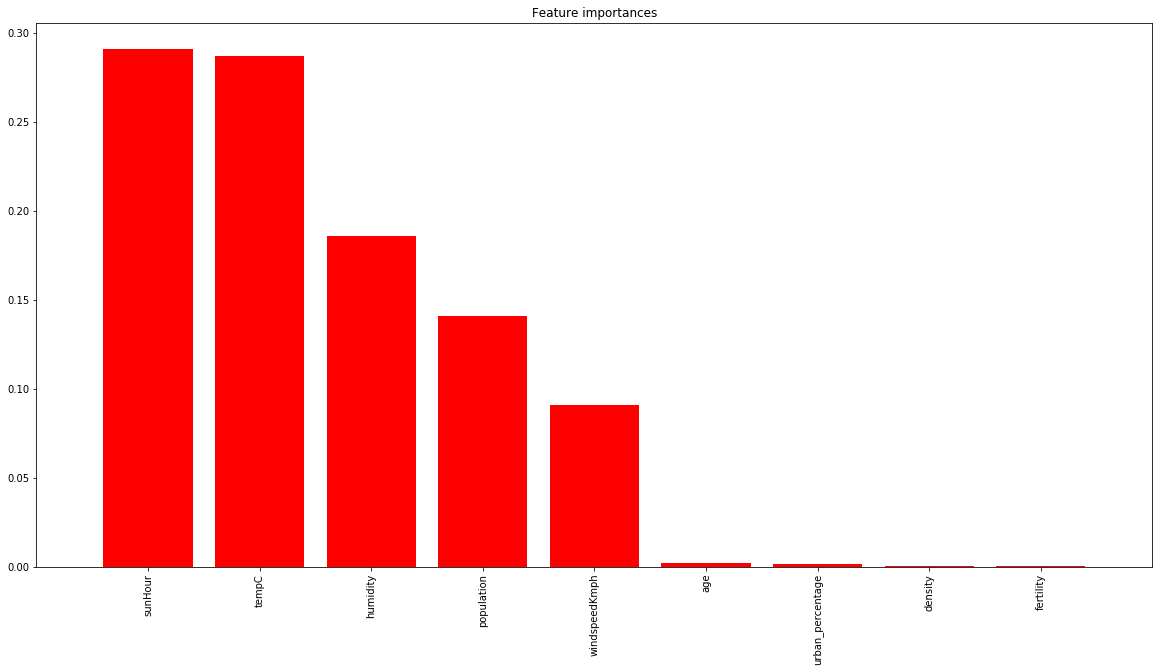

In [76]:
show_feature_importance(model_infected)

From the plot above we can see that many variables are positively correlated to the number of COVID19 infections such as: temperature, hours of sunlight, population, wind speed, humidity, and age. 

These variables should be analyzed carefully as they are not necessaril causal. In terms of population for example, the more people there are in a country, the more likely they are to get infected.
Also, is it possible, that older people are more likely to be infected? Maybe they are also more likely to be tested, and hence confirmed.
Weather conditions can help the virus to spread faster, such as temperature and humidity. It could be that the more hours of sunlight in a country, the more that people will want to be out and interact with social groups.
The percentage of people living in an urban area also has some importance because it signifies a higher density of people, making it easier to transmit the virus.

## Extract Features for Deaths

Feature ranking:
1, Feature: windspeedKmph, Importance: 0.3192842535787319
2, Feature: tempC, Importance: 0.2498977505112476
3, Feature: humidity, Importance: 0.24108384458077708
4, Feature: sunHour, Importance: 0.14396728016359908
5, Feature: age, Importance: 0.016339468302658523
6, Feature: urban_percentage, Importance: 0.009938650306748427
7, Feature: population, Importance: 0.009447852760736194
8, Feature: density, Importance: 0.008404907975460158
9, Feature: fertility, Importance: 0.0016359918200409722


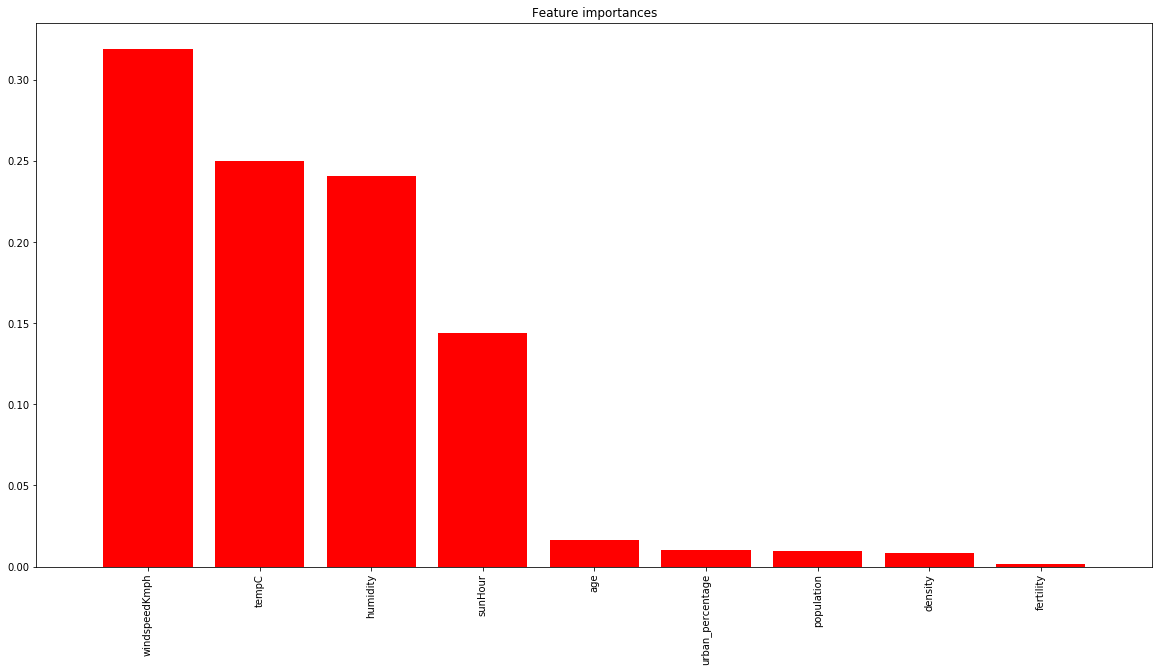

In [77]:
show_feature_importance(model_deaths)

When inspecting the mortality, it appears as if weather conditions are more important than factors such as population, age, and urban percentage. Of course the standard deviation of prediction error should be taken into account, but from this data we can conclude that temperature and humidity are important features for predicting COVID19 mortality.



In [78]:
data['country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Croatia', 'Cuba', 'Cyprus', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Equatorial Guinea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait',
       'Kyrgyzstan', 'Latvia', 'Lebanon', 'Liberia', 'Liechtenstein',
       'Lithuania', 'Luxembourg', 

In [79]:
data_act = data[['country','confirmed','deaths','recovered','active','date']]
data_act = data_act.groupby(['country','date'])[['date',"country","confirmed","deaths","recovered","active"]].sum().sort_values(["date","country"]).reset_index()
data_act

,country,date,confirmed,deaths,recovered,active
0,Afghanistan,2020-01-22,0,0,0,0
1,Albania,2020-01-22,0,0,0,0
2,Algeria,2020-01-22,0,0,0,0
3,Andorra,2020-01-22,0,0,0,0
4,Argentina,2020-01-22,0,0,0,0
5,Armenia,2020-01-22,0,0,0,0
6,Australia,2020-01-22,0,0,0,0
7,Austria,2020-01-22,0,0,0,0
8,Azerbaijan,2020-01-22,0,0,0,0
9,Bahamas,2020-01-22,0,0,0,0


In [80]:
df = pd.read_csv("covid_19_clean.csv",parse_dates=['Date'])

In [81]:
df=df.rename(columns={"Country/Region": "Country"})
df.Country=df["Country"].astype(str)
df_country_all=df.groupby([ "Date","Country"])[["Date", "Country", "Confirmed","Recovered","Deaths", "Lat","Long"]].sum().sort_values(["Date","Country"]).reset_index()
df_country_all.Date=df_country_all["Date"].astype(str)
#df_country=df_country.query("Country==['Italy','US','China','Iran','Spain','France']")
#df_country=df_country[df_country['Date']==df_country.Date.max() & df_country['Confirmed'] > 15000]
df_country_all=df_country_all[df_country_all.Country.isin(df_country_all[(df_country_all['Date']==df_country_all.Date.max())].Country.unique())]
df_country_all["Combined"]=df_country_all["Country"]+ ":" + df_country_all["Confirmed"].astype(str)
df_country_latest=df_country_all[df_country_all.Date==df_country_all.Date.max()]

In [82]:
df_country=df.groupby([ "Date","Country"])[["Date", "Country", "Confirmed","Recovered","Deaths"]].sum().sort_values(["Date","Country"]).reset_index()
df_country.Date=df_country["Date"].astype(str)
#df_country=df_country.query("Country==['Italy','US','China','Iran','Spain','France']")
#df_country=df_country[df_country['Date']==df_country.Date.max() & df_country['Confirmed'] > 15000]
df_country=df_country[df_country.Country.isin(df_country[(df_country['Date']==df_country.Date.max()) & (df_country['Confirmed'] > 10000)].Country.unique())]
df_country["Combined"]=df_country["Country"]+ ":" + df_country["Confirmed"].astype(str)

In [83]:
fig = px.line(df_country, x="Date", y="Confirmed", color="Country",
              line_group="Country", hover_name="Country",title="Trend Of Confirmed Cases For Countries with > 10K Cases")
fig.show()

In [84]:
fig3 = px.line(df_country, x="Date", y="Deaths", color="Country",
              line_group="Country", hover_name="Country",title="Trend Of Mortalities Cases For Countries with > 10K Cases")
fig3.show()

# China VS Rest of the World

In [85]:
df_country.loc[df_country['Country'] == 'China', 'Comp'] = 'CHINA'  
df_country.loc[df_country['Country'] != 'China', 'Comp'] = 'Rest Of the World' 

In [86]:
df_comp1=df_country.groupby([ "Date","Comp"])[["Date", "Comp", "Confirmed","Recovered","Deaths"]].sum().sort_values(["Date","Comp"]).reset_index()
df_comp1.Date=df_comp1["Date"].astype(str)
#df_country=df_country.query("Country==['Italy','US','China','Iran','Spain','France']")
#df_country=df_country[df_country['Date']==df_country.Date.max() & df_country['Confirmed'] > 15000]
#df_comp1=df_comp1[df_comp1.Comp.isin(df_comp1[(df_comp1['Date'] == df_comp1.Date.max())].Comp.unique())]
df_comp1["Combined1"]=df_comp1["Comp"]+ ":" + df_comp1["Recovered"].astype(str)






In [87]:
fig1 = px.line(df_comp1, x="Date", y="Recovered", color="Comp",
              line_group="Comp", hover_name="Comp",title="Trend Of Recovered Cases: China VS Rest of the World ")
fig1.show()

In [88]:
fig2 = px.line(df_comp1, x="Date", y="Deaths", color="Comp",
              line_group="Comp", hover_name="Comp",title="Trend Of Mortality Cases: China VS Rest of the World ")
fig2.show()

## Covid 19 Patients Analysis

Here we have graphs to understand how the infection is ditributed when it comes to age group.
TimeAge is a csv file which has patients info from South Korea.

In [89]:
df_p = pd.read_csv("TimeAge.csv")
df_p.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


In [90]:
df_p.loc[df_p['age'] == '0s', 'int'] = '0 - 20'  
df_p.loc[df_p['age'] == '10s', 'int'] = '0 - 20'  
df_p.loc[df_p['age'] == '20s', 'int'] = '20 - 40'  
df_p.loc[df_p['age'] == '30s', 'int'] = '20 - 40'  
df_p.loc[df_p['age'] == '40s', 'int'] = '40 - 60'  
df_p.loc[df_p['age'] == '50s', 'int'] = '40 - 60'  
df_p.loc[df_p['age'] == '60s', 'int'] = '60 - 80'  
df_p.loc[df_p['age'] == '70s', 'int'] = '60 - 80'  
df_p.loc[df_p['age'] == '80s', 'int'] = '80+'  
df_p.loc[df_p['age'] == '90s', 'int'] = '80+'  
df_p.loc[df_p['age'] == '100s', 'int'] = '80+'  



In [91]:
df_p.head()

,date,time,age,confirmed,deceased,int
0,2020-03-02,0,0s,32,0,0 - 20
1,2020-03-02,0,10s,169,0,0 - 20
2,2020-03-02,0,20s,1235,0,20 - 40
3,2020-03-02,0,30s,506,1,20 - 40
4,2020-03-02,0,40s,633,1,40 - 60


In [92]:
df_p.date=df_p["date"].astype(str)
df_p=df_p.groupby([ "date","int"])[["date", "int", "confirmed","deceased"]].sum().sort_values(["date","int"]).reset_index()




In [93]:
fig4 = px.line(df_p, x="date", y="deceased", color="int",
              line_group="int", hover_name="int",title="Trend of deceased cases based on Age Groups ")
fig4.show()

In [94]:
fig5 = px.line(df_p, x="date", y="confirmed", color="int",
              line_group="int", hover_name="int",title="Trend of Confirmed cases based on Age Groups ")
fig5.show()

Here we can see that the age group between 0-20 are most infected but when it comes to recovery, they are
the one recovering faster. While age group 80+ are least infected and are struggling to recover.